# Setting up 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !ls
# !mkdir drive/My\ Drive/KaggleDataStorm

In [2]:
%cd drive/My\ Drive/KaggleDataStorm

/content/drive/My Drive/KaggleDataStorm


In [0]:
# import os
# os.environ['KAGGLE_USERNAME'] = "ds1047"
# os.environ['KAGGLE_KEY'] = "26ca78d45179f04387b81f35ba031660"

# !kaggle competitions download -c data-storm-10

# Import Libraries & Data

In [0]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
import scipy.stats as stats

from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
train=pd.read_csv("credit_card_default_train.csv.zip")
test=pd.read_csv("credit_card_default_test.csv")

## Utils

In [0]:
def basic_describe(features, train=train):
  """ return basic statistics of the the data"""
  df = train[features].describe()
  pd.options.display.float_format = '{:.2f}'.format
  return df

def calculate_pearson_correlation(train=train):
  corr_array = []
  for column in train.columns:
    if column != 'NEXT_MONTH_DEFAULT':
      data1 = train[column]
      data2 = train['NEXT_MONTH_DEFAULT']
      
      # calculate Pearson's correlation
      corr, _ = pearsonr(data1, data2)
      corr_tup = (column, round(corr, 3))

      corr_array.append(corr_tup)
  return corr_array

def plot_feature(data):
  sns.set(style='darkgrid')
  f, ax = plt.subplots(figsize=(6, 15))
  sns.barplot(x="counts", y="feature", data=data.sort_values(by=['counts']),
            label="Feature Important", color="b")
  plt.show()

In [0]:
def ChiSquaredTestOfIndependence( df, inputVar, Outcome_Category ):
    Outcome_Category_Table = df.groupby( Outcome_Category )[ Outcome_Category ].count().values
    Outcome_Category_Ratios = Outcome_Category_Table / sum( Outcome_Category_Table )
    possibleVals = df[inputVar].unique()
    observed = []
    expected = []
    for possible in possibleVals:
        countsInCategories = df[ df[ inputVar ] == possible ].groupby( Outcome_Category )[Outcome_Category].count().values
        if( len(countsInCategories) != len( Outcome_Category_Ratios ) ):
            print("Error! The class " + str( possible) +" of \'" + inputVar + "\' does not contain all values of \'" + Outcome_Category + "\'" )
            return
        elif( min(countsInCategories) < 5 ):
            print("Chi Squared Test needs at least 5 observations in each cell!")
            print( inputVar + "=" + str(possible) + " has insufficient data")
            print( countsInCategories )
            return
        else:
            observed.append( countsInCategories )   
            expected.append( Outcome_Category_Ratios * len( df[df[ inputVar ] == possible ]))
    observed = np.array( observed )
    expected = np.array( expected )
    chi_squared_stat = ((observed - expected)**2 / expected).sum().sum()
    degOfF = (observed.shape[0] - 1 ) *(observed.shape[1] - 1 ) 
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=degOfF)
    print("Calculated test-statistic is %.2f" % chi_squared_stat )
    print("If " + Outcome_Category + " is indep of " + inputVar + ", this has prob %.2e of occurring" % p_value )

# Feature Engineering

### Categorical Variable Preprocessing

#### load data

In [8]:
train=pd.read_csv("credit_card_default_train.csv.zip")
test=pd.read_csv("credit_card_default_test.csv")

cat_features = ['Balance_Limit_V1', 'Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']
due_features = ['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC']
paid_features = ['PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']
pay_int = ['PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC']

train_test = pd.concat([train, test], axis=0)
train_test.shape

(30000, 25)

In [0]:
# for feature in train_test.columns:
#   if feature != 'NEXT_MONTH_DEFAULT':
#     ChiSquaredTestOfIndependence(train, feature, 'NEXT_MONTH_DEFAULT')
#     print("*********************************")

#### Combine feature for month delayed

In [0]:
for feature in pay_int:
  train_test.loc[train_test[feature] <= 0,feature]=0

train_test['delayed_months'] = train_test[pay_int].sum(axis=1)
train_test['paid_mean'] = train_test[paid_features].mean(axis=1)
train_test['due_mean'] = train_test[due_features].mean(axis=1)
train_test['due_X_paid'] = train_test['due_mean'] * train_test['paid_mean']

In [0]:
months = ['JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
due_paid = []

for month in months:
  train_test['DUE_PAID_'+month] = train_test['DUE_AMT_'+month] - train_test['PAID_AMT_'+month]
  due_paid = due_paid + ['DUE_PAID_'+month]

#### Encoding Categorical Variables

In [0]:
train_test = pd.get_dummies(data=train_test, columns=cat_features, drop_first=False)

In [14]:
drop_columns = ['MARITAL_STATUS_Other', 'Balance_Limit_V1_2.5M', 'Gender_F', 'EDUCATION_STATUS_High School', 'AGE_More than 65']
train_test.drop(columns=drop_columns,inplace=True)
train_test.shape

(30000, 44)

In [15]:
train_processed = train_test[train_test['NEXT_MONTH_DEFAULT'].notna()]
test_processed = train_test[train_test['NEXT_MONTH_DEFAULT'].isna()]

print("Train shape: {}".format(train_processed.shape))
print("Test shape: {}".format(test_processed.shape))

Train shape: (24000, 44)
Test shape: (6000, 44)


### Continuous Variable Preprocessing

In [0]:
for month in due_paid+due_features+paid_features:
  train_processed[month] = train_processed[month].apply(lambda x: np.log1p(x) if (x>0) else 0)
  test_processed[month] = test_processed[month].apply(lambda x: np.log1p(x) if (x>0) else 0)

In [20]:
display(basic_describe(due_paid, train_processed))
display(basic_describe(due_paid, test_processed))

,DUE_PAID_JULY,DUE_PAID_AUG,DUE_PAID_SEP,DUE_PAID_OCT,DUE_PAID_NOV,DUE_PAID_DEC
count,24000.00,24000.00,24000.00,24000.00,24000.00,24000.00
mean,0.97,0.95,0.95,0.94,0.92,0.89
std,0.51,0.53,0.53,0.53,0.54,0.56
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.14,1.11,1.11,1.10,0.00,0.00
50%,1.24,1.24,1.24,1.24,1.24,1.23
75%,1.27,1.27,1.27,1.26,1.26,1.26
max,1.32,1.32,1.33,1.32,1.32,1.32


,DUE_PAID_JULY,DUE_PAID_AUG,DUE_PAID_SEP,DUE_PAID_OCT,DUE_PAID_NOV,DUE_PAID_DEC
count,6000.00,6000.00,6000.00,6000.00,6000.00,6000.00
mean,0.98,0.95,0.94,0.94,0.91,0.90
std,0.51,0.53,0.54,0.53,0.55,0.56
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.14,1.09,1.07,1.08,0.00,0.00
50%,1.24,1.24,1.24,1.24,1.24,1.23
75%,1.27,1.27,1.27,1.26,1.26,1.26
max,1.31,1.31,1.31,1.31,1.31,1.31


# Modelling

In [32]:
drop_features = pay_int + ['Client_ID'] +due_features+paid_features

train_processed.drop(columns=drop_features,inplace=True)

X=train_processed.drop(columns='NEXT_MONTH_DEFAULT')
y=train_processed['NEXT_MONTH_DEFAULT'].astype("int32")

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, shuffle=True,stratify=y, random_state=10)
print("Dropped Features : {}".format(drop_features))

Dropped Features : ['DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV', 'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']


In [22]:
train_processed.shape

(24000, 37)

In [0]:
# from imblearn.over_sampling import SMOTE, ADASYN

# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
# X_train,X_val,y_train,y_val=train_test_split(X_resampled,y_resampled, test_size=0.2, shuffle=True,stratify=y_resampled, random_state=10)

### Base: Random Forest Classifier

In [0]:
n_estimators = [100,200, 250, 300,500]
max_depth = [5, 8, 9, 15, 25]
max_features = ["sqrt", "log2"]
criterion = ["gini", "entropy"]

param_dict = {'n_estimators':n_estimators, 'max_depth':max_depth, "max_features":max_features, "criterion":criterion}

forest = RandomForestClassifier(random_state=1)
grid = GridSearchCV(forest, param_grid=param_dict, cv=5, verbose=1, n_jobs=-1)
best_forest = grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 16.3min


In [0]:
y_pred_rf = best_forest.best_estimator_.predict(X_test)
print("Micro F1: {:.4f}".format(f1_score(y_test, y_pred_rf, average='micro')))
print("Macro F1: {:.4f}".format(f1_score(y_test, y_pred_rf, average='macro')))
print("Weighted F1: {:.4f}".format(f1_score(y_test, y_pred_rf, average='weighted')))

Micro F1: 0.8083
Macro F1: 0.6475
Weighted F1: 0.7799


### LightGBM

In [33]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

grid_param = {"learning_rate": [0.07, 0.05, 0.01],
         "n_estimators" : [8, 16, 32, 64],
         "num_leaves" : [20, 24, 27],
         "lambda_l2" : [1.2, 1.5, 1],
         "colsample_bytree" : [0.7, 0.64, 0.67],
         "bagging_fraction" : [0.7, 0.64, 0.67] 
         }
    
model = lgb.LGBMClassifier(boosting_type='gbdt',
                           objective = "binary",
                           metric = 'binary',
                           n_jobs=-1,
                           silent=True,
                           max_depth = params['max_depth'],
                           max_bin = params['max_bin'],
                           subsample_for_bin = params['subsample_for_bin'],
                           subsample = params['subsample'],
                           subsample_freq = params['subsample_freq'],
                           min_split_gain = params['min_split_gain'],
                           min_child_weight = params['min_child_weight'],
                           min_child_samples = params['min_child_samples'],
                           scale_pos_weight = params['scale_pos_weight']
                           )

grid = GridSearchCV(model, grid_param, verbose=2, cv=20, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 20 folds for each of 972 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 1264 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1994 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2884 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3938 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 5152 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 6530 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 8068 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 9770 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 11632 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 13658 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 15844 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 18194 tasks   

GridSearchCV(cv=20, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, metric='binary',
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0...
                                      subsample=1, subsample_for_bin=200,
                                      subsample_freq=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'bagging_fraction': [0.7, 0.64, 0.67],
                         'colsample_

In [35]:
y_pred_lgbm = grid.best_estimator_.predict(X_test)

print("Micro F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm, average='micro')))
print("Macro F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm, average='macro')))
print("Weighted F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm, average='weighted')))

Micro F1: 0.8117
Macro F1: 0.6544
Weighted F1: 0.7840


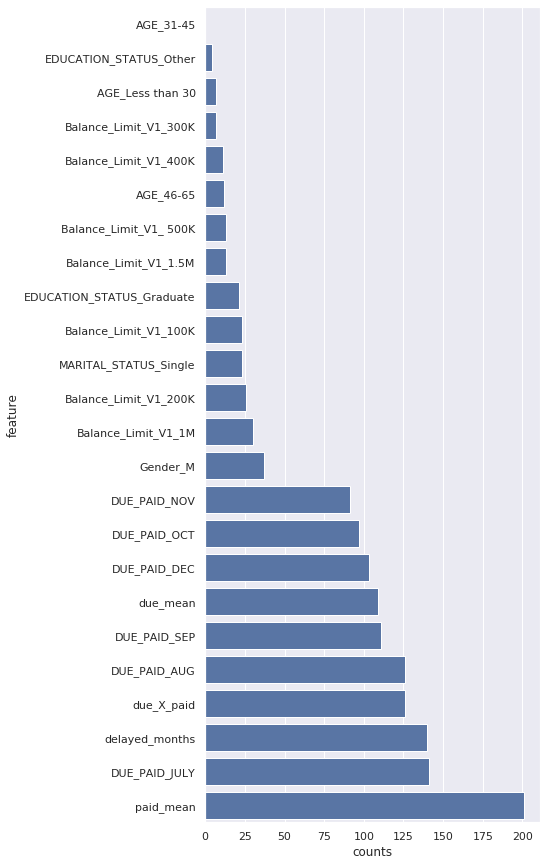

In [48]:
data=pd.DataFrame({"feature":X_train.columns,"counts":grid.best_estimator_.feature_importances_},columns=["feature","counts"])
plot_feature(data)

In [49]:
data = data.sort_values('counts', ascending=False)
display(data)

,feature,counts
1,paid_mean,201
4,DUE_PAID_JULY,141
0,delayed_months,140
3,due_X_paid,126
5,DUE_PAID_AUG,126
6,DUE_PAID_SEP,111
2,due_mean,109
9,DUE_PAID_DEC,103
7,DUE_PAID_OCT,97
8,DUE_PAID_NOV,91


In [0]:
imp_features = data.head(10).feature
imp_features = imp_features.to_numpy()

X_train_best = X_train[imp_features]
X_test_best = X_test[imp_features]

In [51]:
grid.fit(X_train_best, y_train)

Fitting 20 folds for each of 972 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 294 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1996 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2886 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3940 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5154 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6532 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 8070 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 9772 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 11634 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 13660 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 15846 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 18196 tasks   

GridSearchCV(cv=20, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, metric='binary',
                                      min_child_samples=5, min_child_weight=1,
                                      min_split_gain=0.5, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0...
                                      subsample=1, subsample_for_bin=200,
                                      subsample_freq=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'bagging_fraction': [0.7, 0.64, 0.67],
                         'colsample_

In [52]:
y_pred_lgbm_best = grid.best_estimator_.predict(X_test_best)

print("Micro F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm_best, average='micro')))
print("Macro F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm_best, average='macro')))
print("Weighted F1: {:.4f}".format(f1_score(y_test, y_pred_lgbm_best, average='weighted')))

Micro F1: 0.8117
Macro F1: 0.6482
Weighted F1: 0.7815


# Pearson Correlation Between Features and Default

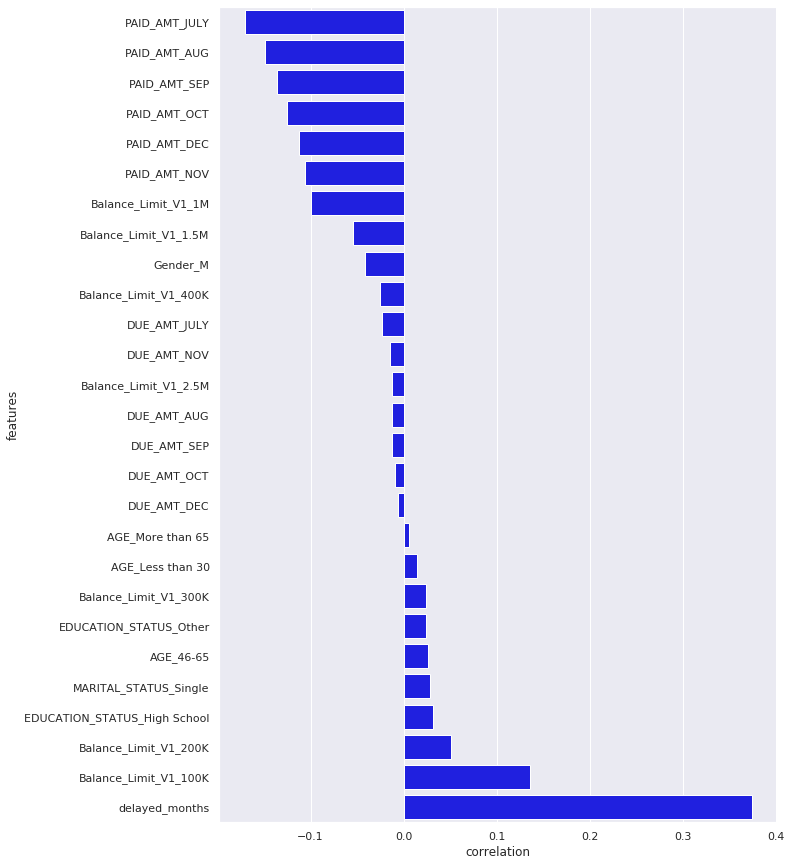

In [0]:
correlations = dict(calculate_pearson_correlation(X_train)) 
df = pd.DataFrame(list(correlations.items()), columns=['features', 'correlation'])
df = df.sort_values(by=['correlation'])

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x="correlation", y="features", data=df,
          label="Feature Important", color="blue")
plt.show()

# Export Test Results

In [0]:
test_processed.head()

,Client_ID,DUE_AMT_AUG,DUE_AMT_DEC,DUE_AMT_JULY,DUE_AMT_NOV,DUE_AMT_OCT,DUE_AMT_SEP,NEXT_MONTH_DEFAULT,PAID_AMT_AUG,PAID_AMT_DEC,PAID_AMT_JULY,PAID_AMT_NOV,PAID_AMT_OCT,PAID_AMT_SEP,PAY_AUG,PAY_DEC,PAY_JULY,PAY_NOV,PAY_OCT,PAY_SEP,delayed_months,due_total,Balance_Limit_V1_1.5M,Balance_Limit_V1_100K,Balance_Limit_V1_1M,Balance_Limit_V1_2.5M,Balance_Limit_V1_200K,Balance_Limit_V1_300K,Balance_Limit_V1_400K,Gender_M,EDUCATION_STATUS_High School,EDUCATION_STATUS_Other,MARITAL_STATUS_Single,AGE_46-65,AGE_Less than 30,AGE_More than 65
0,A20170,198510,352206,194188,351790,311201,128316,nan,9.46,9.47,9.53,9.76,10.88,12.18,0,0,0,0,0,0,0,1536211,0,0,0,0,0,0,0,1,0,1,1,0,0,0
1,A16887,89427,100275,87115,97221,94181,91823,nan,8.25,8.44,8.23,8.44,8.44,8.27,0,0,0,0,0,0,0,560042,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,A3430,9573,993,2693,9561,11294,8984,nan,0.00,10.60,8.84,7.75,0.00,7.75,0,0,0,0,0,2,2,43098,0,0,0,0,0,0,1,1,0,1,0,0,1,0
3,A3696,5775,0,0,0,0,5775,nan,8.66,0.00,8.66,0.00,0.00,0.00,0,0,1,0,0,0,1,11550,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,A20474,0,0,85257,0,0,0,nan,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,85257,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [0]:
test_processed_clinet=test_processed['Client_ID']

In [60]:
drop_features = due_features + paid_features + pay_int + ['Client_ID', 'NEXT_MONTH_DEFAULT']
# test_data=test_processed.drop(columns=drop_features, inplace=True)
test_data = test_processed[imp_features]
test_data.shape

(6000, 10)

In [0]:
y_pred_test = grid.best_estimator_.predict(test_data)

In [0]:
test_processed_clinet = test_processed_clinet.to_numpy()

In [0]:
data = {'Client_ID': test_processed_clinet, 'NEXT_MONTH_DEFAULT': y_pred_test}

In [67]:
results = pd.DataFrame(data)
results.head()

,Client_ID,NEXT_MONTH_DEFAULT
0,A20170,0
1,A16887,0
2,A3430,0
3,A3696,0
4,A20474,0


In [0]:
results.to_csv("results_4.csv", index=False)